In [1]:
%load_ext black

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import io
import math
import requests

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss
from sklearn.model_selection import train_test_split
from lightgbm import LGBMClassifier

plt.style.use('ggplot')

The black module is not an IPython extension.


In [2]:
# Define the competition scorer
def competition_scorer(y_true, y_pred):
    return log_loss(y_true, y_pred, sample_weight=10**y_true)

# 1- Information about the challenge

In this challenge, the `requests` dataset contains information about the requests made by group of individuals (or family) to the french emergency housing public service. A sample of the `requests` dataset corresponds to a unique request.

The goal is to predict the categorical variable `granted_number_of_nights` which represents the number of nights of emergency housing granted to a group. You can train your model on the `train_requests`, the predictions should be made for requests listed in the `test_requests` dataset.

The evaluation metric is given by the `competition_scorer` defined above. It corresponds to a weighted log-loss with weights 1, 10, 100, or 1000 if the `granted_number_of_nights` takes the value 0, 1, 2, or 3 respectively. Thus beware that you will be penalized harder for classification mistakes made on the higher labels.

Good luck!

# 2- Load the datasets

In [3]:
# Train sample
requests_train = pd.read_csv('data/train_requests.csv', sep=',', low_memory=False, error_bad_lines=False)

# Test sample
requests_test = pd.read_csv('data/test_requests.csv', sep=',', low_memory=False, error_bad_lines=False)

b'Skipping line 31303: expected 24 fields, saw 49\nSkipping line 75954: expected 24 fields, saw 49\n'


In [4]:
# Train sample
individuals_train = pd.read_csv('data/train_individuals.csv', sep=',', low_memory=False, error_bad_lines=False)

# Test sample
individuals_test = pd.read_csv('data/test_individuals.csv', sep=',', low_memory=False, error_bad_lines=False)

In [5]:
train_data = requests_train.merge(individuals_train.groupby('request_id').mean(), left_on='request_id', right_index=True)
test_data = requests_test.merge(individuals_test.groupby('request_id').mean(), left_on='request_id', right_index=True)


In [6]:
train_data.head()

,request_id,animal_presence,answer_creation_date,child_situation,child_to_come,district,granted_number_of_nights,group_composition_id,group_composition_label,group_creation_date,...,requester_type,social_situation_id,town,victim_of_violence,victim_of_violence_type,housing_situation_2_id,birth_month,birth_year,individual_role_2_id,marital_status_id
0,130667d2964de43c511d0ead7ac66b33,f,2019-02-11 22:30:00,-1,NaN,85,1,10,man alone,2018-05-03 12:10:40.416,...,third party,9a84febc47fedaf2c81d7c755e9edc85,NaN,f,NaN,20.0,5.0,1977.0,30.0,10.0
1,b1cd62fcf24eebb0f685d5eaf55317a8,f,2019-02-12 09:00:00,-1,NaN,85,1,10,man alone,2019-03-07 12:11:08.545,...,user,11f64f0547e855c5c59329b9edc63063,NaN,f,NaN,20.0,5.0,1980.0,30.0,-1.0
2,12cc0a18890bd4959fe42df3ae58838e,f,2019-02-01 21:00:00,-1,NaN,59,1,80,isolated child/underage,2019-03-13 12:54:15.887,...,user,898ab2883f410f4c6fb042ef16329fbb,NaN,f,NaN,20.0,1.0,2003.0,10.0,-1.0
3,ae2d5b4dc181d29e430132f145da1556,f,2019-02-25 15:12:05.037,-1,NaN,50,2,20,woman alone,2018-10-09 14:37:29.773,...,user,3998c8e890ddc980527dd1af45dfa672,NaN,t,woman,20.0,7.0,1986.0,30.0,-1.0
4,d13a17ce36c832514fda2464e11c4a9f,f,2019-02-20 09:59:20.603,-1,NaN,93,2,60,group with child(ren),2018-10-02 10:47:36.931,...,user,74a10d96eae43586bc3c46e89719b821,NaN,f,NaN,35.0,7.0,1987.0,24.0,-1.0


In [7]:
requests_train.describe().columns

Index(['child_situation', 'district', 'granted_number_of_nights',
       'group_composition_id', 'housing_situation_id', 'number_of_underage'],
      dtype='object')

# 3-Feature engineering / selection

In [8]:
# selected columns for explanatory variable
numerical = ['child_situation', 'number_of_underage', 'birth_year']
categorical = ['animal_presence', 'child_to_come', 'district', 'group_composition_id',
              'long_term_housing_request',
              'requester_type', 'town', 'victim_of_violence', 'victim_of_violence_type',
              'housing_situation_id', 'birth_month', 'individual_role_2_id', 'marital_status_id']
for i in categorical:
    train_data[i] = train_data[i].astype('category')
    test_data[i] = test_data[i].astype('category')
to_keep = numerical + categorical
X = train_data[to_keep]
y = train_data['granted_number_of_nights']

# 4-Model selection

In [9]:
# split between the train and the validation samples
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.33, random_state=37)

In [10]:
model = LGBMClassifier(n_estimators=1000, max_depth=10, learning_rate=.01)

In [11]:
# fit the model
model.fit(X_train, y_train, eval_set=[(X_val, y_val)],
          early_stopping_rounds=200,
          sample_weight=10**y_train,  # Necessary to train the model well.
          verbose=50,
          eval_sample_weight=[10**y_val]  # Necessary to get reliable validation loss for early stopping
         )

Training until validation scores don't improve for 200 rounds.
[50]	valid_0's multi_logloss: 1.00983
[100]	valid_0's multi_logloss: 0.821312
[150]	valid_0's multi_logloss: 0.718377
[200]	valid_0's multi_logloss: 0.661103
[250]	valid_0's multi_logloss: 0.629348
[300]	valid_0's multi_logloss: 0.610812
[350]	valid_0's multi_logloss: 0.600731
[400]	valid_0's multi_logloss: 0.594404
[450]	valid_0's multi_logloss: 0.591606
[500]	valid_0's multi_logloss: 0.591107
[550]	valid_0's multi_logloss: 0.592046
[600]	valid_0's multi_logloss: 0.594317
[650]	valid_0's multi_logloss: 0.597018
Early stopping, best iteration is:
[484]	valid_0's multi_logloss: 0.590859


LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.01, max_depth=10,
        min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
        n_estimators=1000, n_jobs=-1, num_leaves=31, objective=None,
        random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
        subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [12]:
# Evaluate the model with the competition scorer (validation set)
# Check it matches eval score from lgbm model
y_val_pred = model.predict_proba(X_val)
competition_scorer(y_val, y_val_pred)

0.5908591787213787

# 5- Compute predictions on the test set 

In [13]:
# use the model to predict on the test set.
X_test = test_data[to_keep]
y_pred = model.predict_proba(X_test)

In [14]:
# overview of prediction probabilities for first four rows
y_pred[:4]

array([[0.01610912, 0.1635891 , 0.61385995, 0.20644183],
       [0.09144336, 0.45075529, 0.43516109, 0.02264025],
       [0.01683933, 0.12306728, 0.84428788, 0.01580551],
       [0.22712627, 0.16944   , 0.05825342, 0.54518032]])

In [15]:
predictions = pd.concat([requests_test['request_id'], pd.DataFrame(y_pred)], axis=1)

# 6- Submit your predictions to the QScore platform

In [16]:
# Get your token from qscore:
# 1. Go to https://qscore.datascience-olympics.com/
# 2. Chose the competition Data Science Olympics 2019
# 3. In the left menu click 'Submissions'
# 4. Your token is in the 'Submit from your Python Notebook' tab

def submit_prediction(df, sep=',', comment='', compression='gzip', **kwargs):
    TOKEN=''
    URL='https://qscore.datascience-olympics.com/api/submissions'
    df.to_csv('temporary.dat', sep=sep, compression=compression, **kwargs)
    r = requests.post(URL, headers={'Authorization': 'Bearer {}'.format(TOKEN)},files={'datafile': open('temporary.dat', 'rb')},data={'comment':comment, 'compression': compression})
    if r.status_code == 429:
        raise Exception('Submissions are too close. Next submission is only allowed in {} seconds.'.format(int(math.ceil(int(r.headers['x-rate-limit-remaining']) / 1000.0))))
    if r.status_code != 200:
        raise Exception(r.text)

In [17]:
#submit_prediction(predictions, sep=',', index=False, comment='my submission')

# 7-Visualise / interpret predictions

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f88ed9abc88>,
      dtype=object)

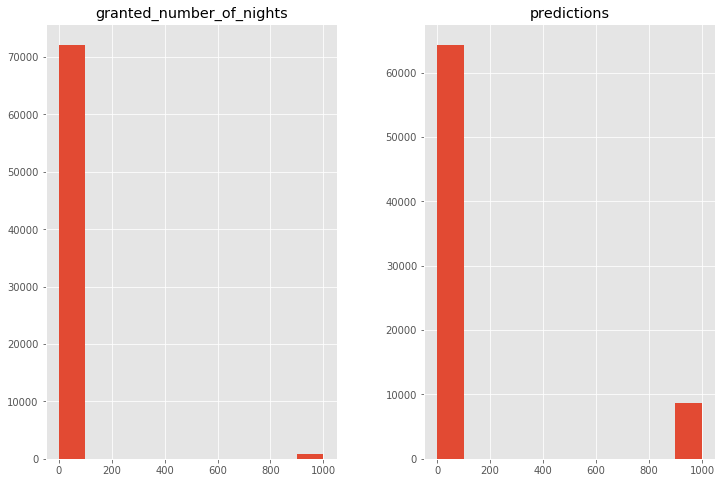

In [18]:
pd.concat([10**y_val, 10**pd.Series(y_val_pred.argmax(axis=1), index=y_val.index, name='predictions')], axis=1).hist(figsize=(12, 8))

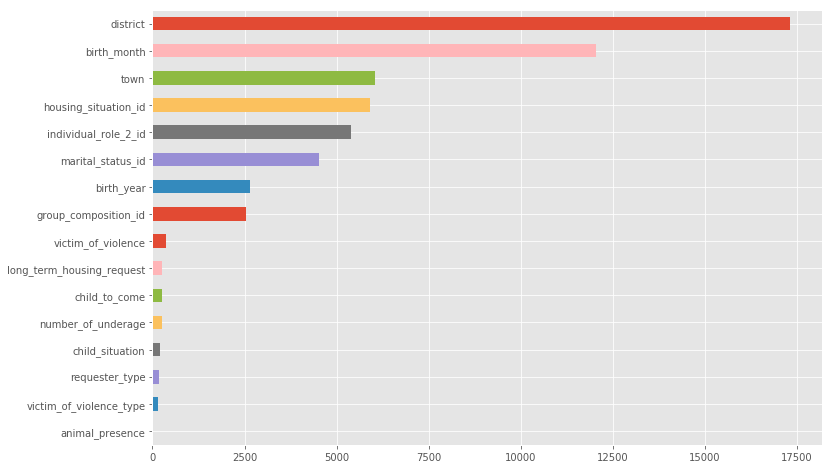

In [19]:
pd.Series(model.feature_importances_, index=X_train.columns).sort_values().plot(kind='barh', figsize=(12, 8))